In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pylab as pl
from sklearn import linear_model
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
%matplotlib inline

# Campaign Stats Exploratory

In [19]:
#read campaign stats dataset
new_camp_raw = pd.read_csv("camp_stat.csv")
new_camp_raw.head()

,id,campaign_id,date,clicks,spent,impressions,conversions,objective
0,2,6027527674303,1436737612696,9,11.60,799,0,WEBSITE_CONVERSIONS
1,3,6027528000703,1436737616881,68,33.27,4343,1,WEBSITE_CONVERSIONS
2,4,6027529267903,1436737627362,99,41.29,7295,2,WEBSITE_CONVERSIONS
3,5,6027417795703,1436737694531,285,119.44,14541,4,WEBSITE_CONVERSIONS
4,6,6030433161770,1436737714992,1836,1277.87,153110,934,MOBILE_APP_INSTALLS


In [20]:
#read adset stats dataset
new_adset_raw = pd.read_csv("adset_stat.csv")
new_adset_raw.head()

,id,adset_id,campaign_id,date,clicks,spent,impressions,conversions,objective
0,2,6027527676303,6027527674303,1436737612696,9,11.60,799,0,WEBSITE_CONVERSIONS
1,3,6027528002503,6027528000703,1436737616881,68,33.27,4343,1,WEBSITE_CONVERSIONS
2,4,6027529269703,6027529267903,1436737627362,99,41.29,7295,2,WEBSITE_CONVERSIONS
3,5,6027417797303,6027417795703,1436737694531,285,119.44,14541,4,WEBSITE_CONVERSIONS
4,6,6030433163570,6030433161770,1436737714992,1836,1277.87,153110,934,MOBILE_APP_INSTALLS


In [21]:
len(new_camp_raw.campaign_id.unique())

3454

In [22]:
# Convert utc date/time into readable datatime object into a new column 
new_camp_raw['readable_date'] = pd.to_datetime(new_camp_raw['date'],unit='ms')

In [23]:
len(new_camp_raw)

130784

In [24]:
# Group By campaign id and get date max for every campaign to get the last recorded stats value
new_camp_raw['date_max'] = new_camp_raw.groupby(['campaign_id'])['date'].transform(max)

In [25]:
idx = new_camp_raw['date_max'] == new_camp_raw['date']
new_camp_max = new_camp_raw[idx]

In [26]:
len(new_camp_max)

3454

In [27]:
# Print correlations between campaign stats feilds
new_camp_max.corr()

,id,campaign_id,date,clicks,spent,impressions,conversions,date_max
id,1.000000,0.725587,0.996258,-0.016943,-0.001942,-0.028880,0.019943,0.996258
campaign_id,0.725587,1.000000,0.726499,-0.100383,-0.093485,-0.106136,-0.043887,0.726499
date,0.996258,0.726499,1.000000,-0.015721,-0.000110,-0.027728,0.020511,1.000000
clicks,-0.016943,-0.100383,-0.015721,1.000000,0.609710,0.862102,0.676338,-0.015721
spent,-0.001942,-0.093485,-0.000110,0.609710,1.000000,0.529708,0.347329,-0.000110
impressions,-0.028880,-0.106136,-0.027728,0.862102,0.529708,1.000000,0.429436,-0.027728
conversions,0.019943,-0.043887,0.020511,0.676338,0.347329,0.429436,1.000000,0.020511
date_max,0.996258,0.726499,1.000000,-0.015721,-0.000110,-0.027728,0.020511,1.000000


In [28]:
new_camp_max.describe()

,id,campaign_id,date,clicks,spent,impressions,conversions,date_max
count,3454.000000,3.454000e+03,3.454000e+03,3454.000000,3454.000000,3454.000000,3454.000000,3.454000e+03
mean,64860.712218,6.036459e+12,1.449856e+12,3093.199189,681.556497,194184.497105,2739.557035,1.449856e+12
std,38732.518676,6.027056e+09,6.563293e+09,23204.795693,6598.758436,2150604.152885,19904.952240,6.563293e+09
min,124.000000,6.009724e+12,1.436860e+12,0.000000,0.000000,1.000000,0.000000,1.436860e+12
25%,31526.500000,6.032088e+12,1.444885e+12,68.250000,22.505000,5005.750000,11.000000,1.444885e+12
50%,62729.000000,6.035864e+12,1.449273e+12,334.500000,78.555000,20366.000000,119.000000,1.449273e+12
75%,97751.250000,6.040657e+12,1.455898e+12,1250.250000,281.312500,77414.250000,658.000000,1.455898e+12
max,130785.000000,6.056712e+12,1.460237e+12,841512.000000,271614.710000,68916999.000000,603245.000000,1.460237e+12


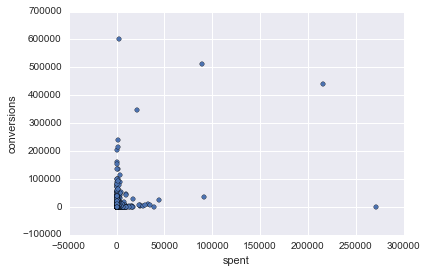

In [29]:
# Plotting the relation between clicks and conversions
new_camp_max.plot(kind = 'scatter', x = 'spent', y = 'conversions')

In [30]:
#Define function to remove outliers in conversions
def drop_conversions_outliers(df):
    print 'Dropping outliers'
    print '- n (before) =', len(df)

    Q1 = df.conversions.quantile(.25)
    Q2 = df.conversions.quantile(.5)
    Q3 = df.conversions.quantile(.75)
    IQR = Q3 - Q1

    print '- Q1         =', Q1, '($M)'
    print '- Q2/Median  =', Q2, '($M)'
    print '- Q3         =', Q3, '($M)'

    df.drop(df[(df.conversions < Q1 - 1.5 * IQR) | (df.conversions > Q3 + 1.5 * IQR)].index, inplace = True)

    print '- n (after)  =', len(df)

In [31]:
#Define function to remove outliers in spent
def drop_spent_outliers(df):
    print 'Dropping outliers'
    print '- n (before) =', len(df)

    Q1 = df.spent.quantile(.25)
    Q2 = df.spent.quantile(.5)
    Q3 = df.spent.quantile(.75)
    IQR = Q3 - Q1

    print '- Q1         =', Q1, '($M)'
    print '- Q2/Median  =', Q2, '($M)'
    print '- Q3         =', Q3, '($M)'

    df.drop(df[(df.spent < Q1 - 1.5 * IQR) | (df.spent > Q3 + 1.5 * IQR)].index, inplace = True)

    print '- n (after)  =', len(df)

In [189]:
#Define function to remove clicks in spent
def drop_clicks_outliers(df):
    print 'Dropping outliers'
    print '- n (before) =', len(df)

    Q1 = df.clicks.quantile(.25)
    Q2 = df.clicks.quantile(.5)
    Q3 = df.clicks.quantile(.75)
    IQR = Q3 - Q1

    print '- Q1         =', Q1, '($M)'
    print '- Q2/Median  =', Q2, '($M)'
    print '- Q3         =', Q3, '($M)'

    df.drop(df[(df.clicks < Q1 - 1.5 * IQR) | (df.clicks > Q3 + 1.5 * IQR)].index, inplace = True)

    print '- n (after)  =', len(df)

In [190]:
drop_spent_outliers(new_camp_max)

Dropping outliers
- n (before) = 2416
- Q1         = 14.6725 ($M)
- Q2/Median  = 40.42 ($M)
- Q3         = 114.305 ($M)
- n (after)  = 2189


In [33]:
drop_conversions_outliers(new_camp_max)

Dropping outliers
- n (before) = 3038
- Q1         = 8.0 ($M)
- Q2/Median  = 91.5 ($M)
- Q3         = 471.75 ($M)
- n (after)  = 2624


/Users/Edie/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


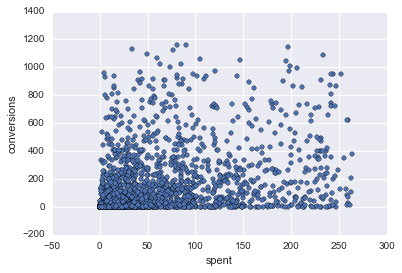

In [191]:
new_camp_max.plot(kind = 'scatter', x = 'spent', y = 'conversions')

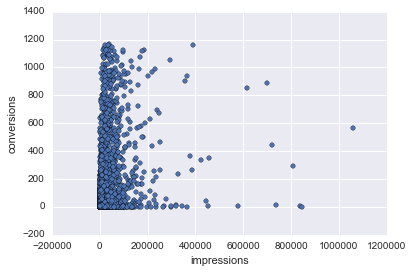

In [37]:
new_camp_max.plot(kind = 'scatter', x = 'impressions', y = 'conversions')

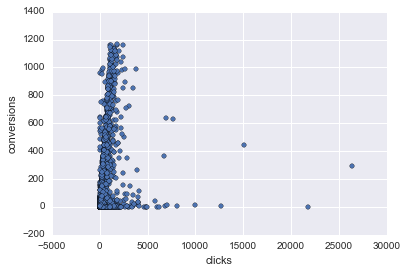

In [38]:
new_camp_max.plot(kind = 'scatter', x = 'clicks', y = 'conversions')

In [40]:
drop_clicks_outliers(new_camp_max)

Dropping outliers
- n (before) = 2624
- Q1         = 43.0 ($M)
- Q2/Median  = 170.0 ($M)
- Q3         = 508.0 ($M)
- n (after)  = 2416


/Users/Edie/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


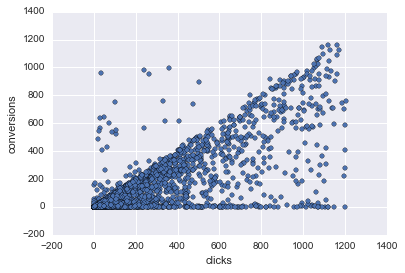

In [41]:
new_camp_max.plot(kind = 'scatter', x = 'clicks', y = 'conversions')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x113875bd0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11430ff90>]], dtype=object)

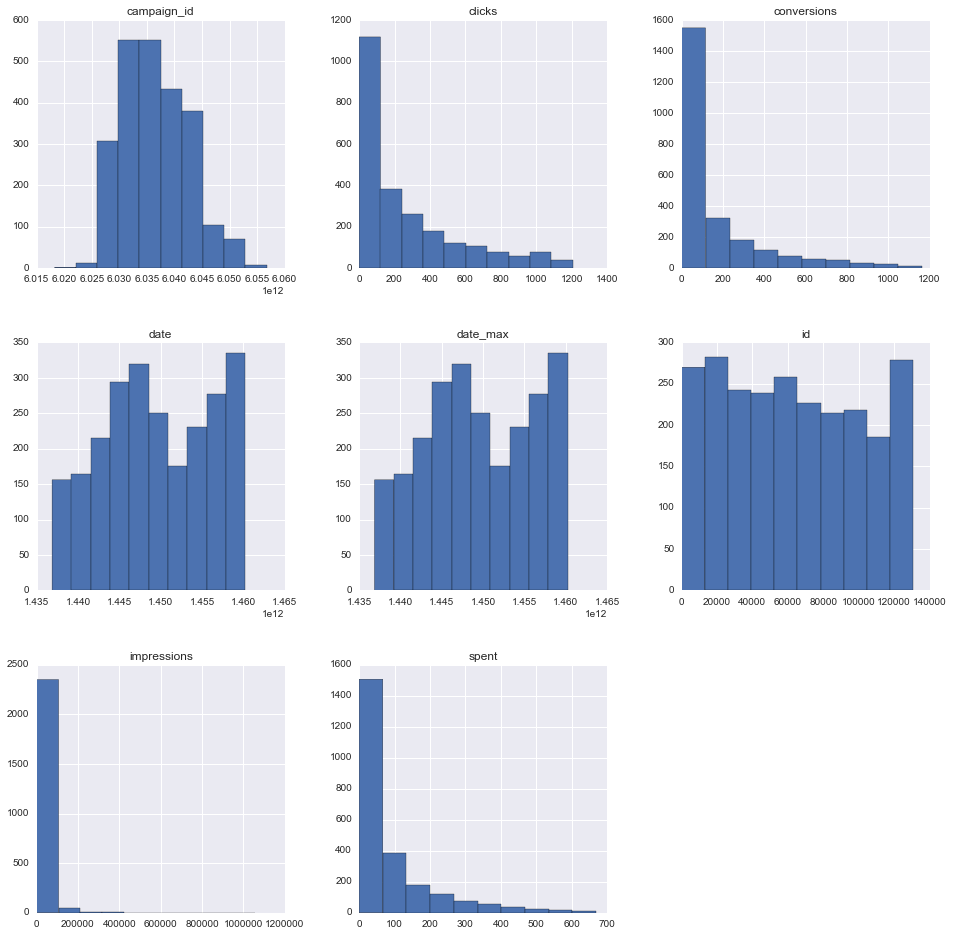

In [42]:
new_camp_max.hist(figsize=(16,16))

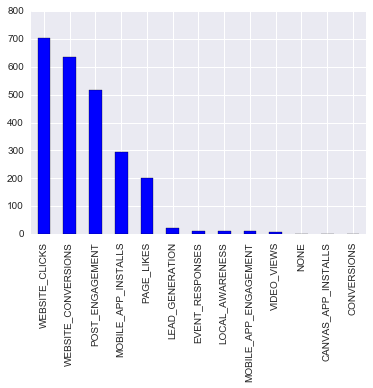

In [44]:
# Bar Blot showing Most used objectives within campaign objectives column 
new_camp_max.objective.value_counts().plot(kind='bar')

In [45]:
# Get the most used objective associated with campaigns
new_camp_max.groupby('objective').spent.sum().sort()
# sum spent
objective_spent = new_camp_max.groupby(['objective'],as_index=False).spent.sum()
objective_spent.columns = ['objective', 'sum_spent']
objective_spent.sort(['sum_spent'])

/Users/Edie/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort is deprecated, use sort_values(inplace=True) for for INPLACE sorting
  from ipykernel import kernelapp as app
/Users/Edie/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,objective,sum_spent
1,CONVERSIONS,0.44
10,VIDEO_VIEWS,38.81
7,NONE,272.92
0,CANVAS_APP_INSTALLS,440.22
2,EVENT_RESPONSES,790.28
5,MOBILE_APP_ENGAGEMENT,873.13
3,LEAD_GENERATION,1650.40
4,LOCAL_AWARENESS,2023.05
8,PAGE_LIKES,17704.42
9,POST_ENGAGEMENT,31868.69


# Adset Stats Exploratory

In [47]:
new_adset_raw = pd.read_csv("adset_stat.csv")

In [48]:
new_adset_raw.head()

,id,adset_id,campaign_id,date,clicks,spent,impressions,conversions,objective
0,2,6027527676303,6027527674303,1436737612696,9,11.60,799,0,WEBSITE_CONVERSIONS
1,3,6027528002503,6027528000703,1436737616881,68,33.27,4343,1,WEBSITE_CONVERSIONS
2,4,6027529269703,6027529267903,1436737627362,99,41.29,7295,2,WEBSITE_CONVERSIONS
3,5,6027417797303,6027417795703,1436737694531,285,119.44,14541,4,WEBSITE_CONVERSIONS
4,6,6030433163570,6030433161770,1436737714992,1836,1277.87,153110,934,MOBILE_APP_INSTALLS


In [49]:
len(new_adset_raw.adset_id.unique())

10266

In [50]:
# Convert utc date/time into readable datatime object into a new column 
new_adset_raw['readable_date'] = pd.to_datetime(new_adset_raw['date'],unit='ms')

In [51]:
# Group By adset id and get date max for every adset to get the last recorded stats value
new_adset_raw['date_max'] = new_adset_raw.groupby(['adset_id'])['date'].transform(max)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x116eb80d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1178bd5d0>]], dtype=object)

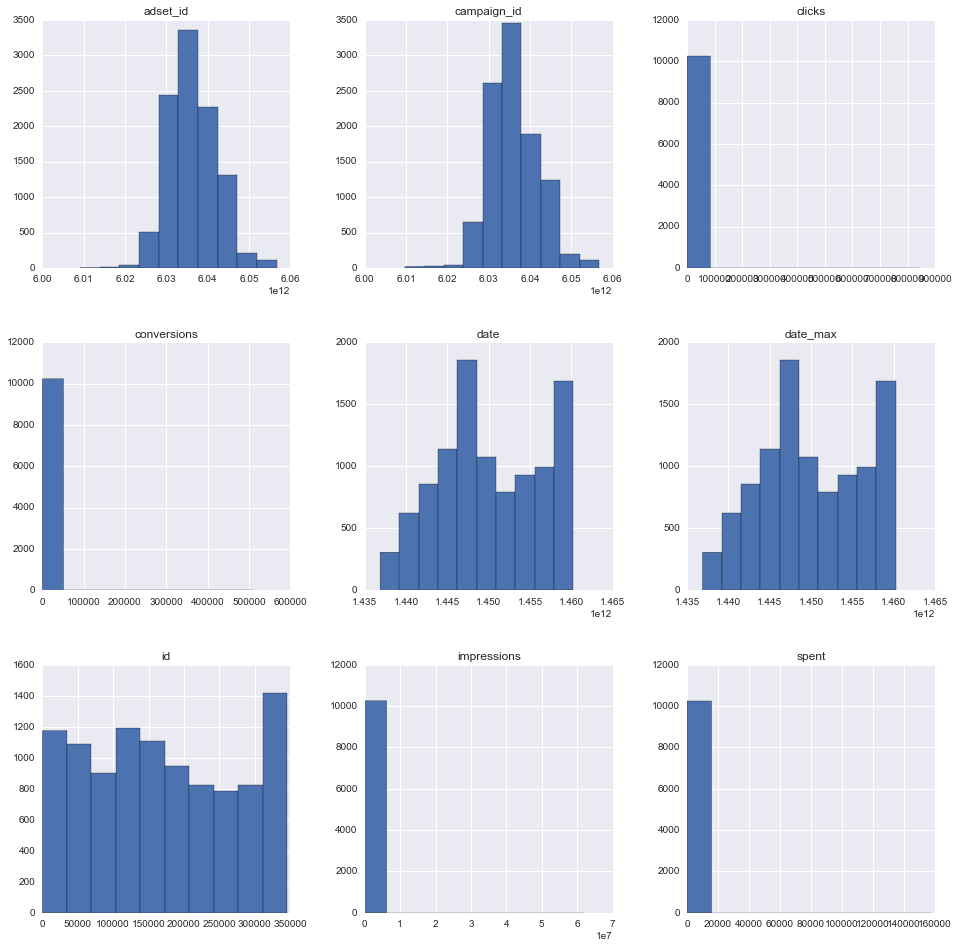

In [52]:
idx = new_adset_raw['date_max'] == new_adset_raw['date']
new_adset_raw[idx]
new_adset_max = new_adset_raw[idx]
new_adset_max.hist(figsize=(16,16))

In [53]:
new_adset_max.corr()

,id,adset_id,campaign_id,date,clicks,spent,impressions,conversions,date_max
id,1.000000,0.780449,0.764794,0.995545,-0.017325,-0.011558,-0.027632,0.014460,0.995545
adset_id,0.780449,1.000000,0.988792,0.780180,-0.067872,-0.079531,-0.081527,-0.035253,0.780180
campaign_id,0.764794,0.988792,1.000000,0.764482,-0.071693,-0.080825,-0.085298,-0.034039,0.764482
date,0.995545,0.780180,0.764482,1.000000,-0.016944,-0.010098,-0.027175,0.014123,1.000000
clicks,-0.017325,-0.067872,-0.071693,-0.016944,1.000000,0.536613,0.857367,0.766851,-0.016944
spent,-0.011558,-0.079531,-0.080825,-0.010098,0.536613,1.000000,0.519352,0.356844,-0.010098
impressions,-0.027632,-0.081527,-0.085298,-0.027175,0.857367,0.519352,1.000000,0.584172,-0.027175
conversions,0.014460,-0.035253,-0.034039,0.014123,0.766851,0.356844,0.584172,1.000000,0.014123
date_max,0.995545,0.780180,0.764482,1.000000,-0.016944,-0.010098,-0.027175,0.014123,1.000000


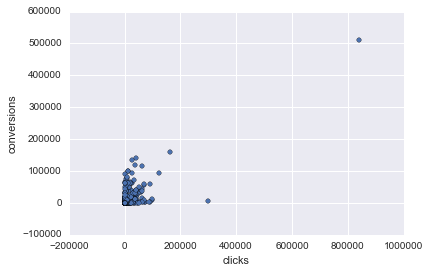

In [54]:
new_adset_max.plot(kind = 'scatter', x = 'clicks', y = 'conversions')

In [55]:
drop_conversions_outliers(new_adset_max)

Dropping outliers
- n (before) = 10266
- Q1         = 2.0 ($M)
- Q2/Median  = 26.0 ($M)
- Q3         = 213.0 ($M)
- n (after)  = 8767


/Users/Edie/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


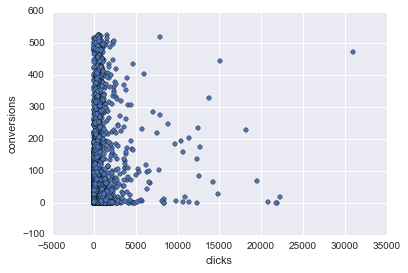

In [56]:
new_adset_max.plot(kind = 'scatter', x = 'clicks', y = 'conversions')

In [57]:
drop_clicks_outliers(new_adset_max)

Dropping outliers
- n (before) = 8767
- Q1         = 12.0 ($M)
- Q2/Median  = 58.0 ($M)
- Q3         = 229.0 ($M)
- n (after)  = 7971


/Users/Edie/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


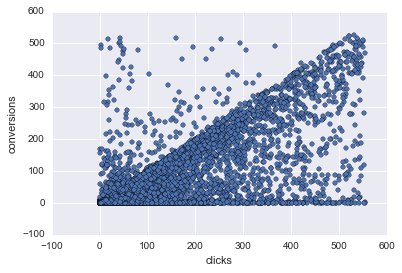

In [58]:
new_adset_max.plot(kind = 'scatter', x = 'clicks', y = 'conversions')

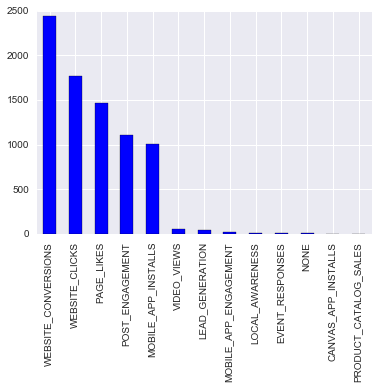

In [60]:
new_adset_max.objective.value_counts().plot(kind='bar')

In [61]:
# Get the most used objective associated with adsets
new_adset_max.groupby('objective').spent.sum().sort()
adset_objective_spent = new_adset_max.groupby(['objective'],as_index=False).spent.sum()
adset_objective_spent.columns = ['objective', 'sum_spent']
adset_objective_spent.sort(['sum_spent'])

/Users/Edie/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort is deprecated, use sort_values(inplace=True) for for INPLACE sorting
  from ipykernel import kernelapp as app
/Users/Edie/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,objective,sum_spent
9,PRODUCT_CATALOG_SALES,174.40
6,NONE,272.92
0,CANVAS_APP_INSTALLS,440.22
1,EVENT_RESPONSES,476.81
4,MOBILE_APP_ENGAGEMENT,783.79
10,VIDEO_VIEWS,1758.79
2,LEAD_GENERATION,2251.14
3,LOCAL_AWARENESS,2724.68
7,PAGE_LIKES,32803.68
8,POST_ENGAGEMENT,36705.95


# Ad Exploratory

In [62]:
new_ad_raw = pd.read_csv("ad_stat.csv")

In [63]:
new_ad_raw.head()

,id,ad_id,adset_id,campaign_id,date,clicks,spent,impressions,conversions,objective
0,2,NaN,NaN,6027527674303,1.436738e+12,0,0.02,2,0,WEBSITE_CONVERSIONS
1,3,NaN,NaN,6027527674303,1.436738e+12,0,0.09,5,0,WEBSITE_CONVERSIONS
2,4,NaN,NaN,6027527674303,1.436738e+12,0,0.09,4,0,WEBSITE_CONVERSIONS
3,5,NaN,NaN,6027527674303,1.436738e+12,9,11.10,769,0,WEBSITE_CONVERSIONS
4,6,NaN,NaN,6027527674303,1.436738e+12,0,0.30,19,0,WEBSITE_CONVERSIONS


In [ ]:
#Delete NaN columns
new_ad_raw = new_ad_raw.drop('ad_id', 1)

In [73]:
new_ad_raw = new_ad_raw.drop('adset_id', 1)

In [74]:
len(new_ad_raw.campaign_id.unique())

3412

In [75]:
new_ad_raw['readable_date'] = pd.to_datetime(new_ad_raw['date'],unit='ms')

In [76]:
len(new_ad_raw)

8057374

In [77]:
new_ad_raw['date_max'] = new_ad_raw.groupby(['campaign_id'])['date'].transform(max)
idx = new_ad_raw['date_max'] == new_ad_raw['date']
new_ad_raw[idx]
new_ad_max = new_ad_raw[idx]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x121d05690>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x143404d90>]], dtype=object)

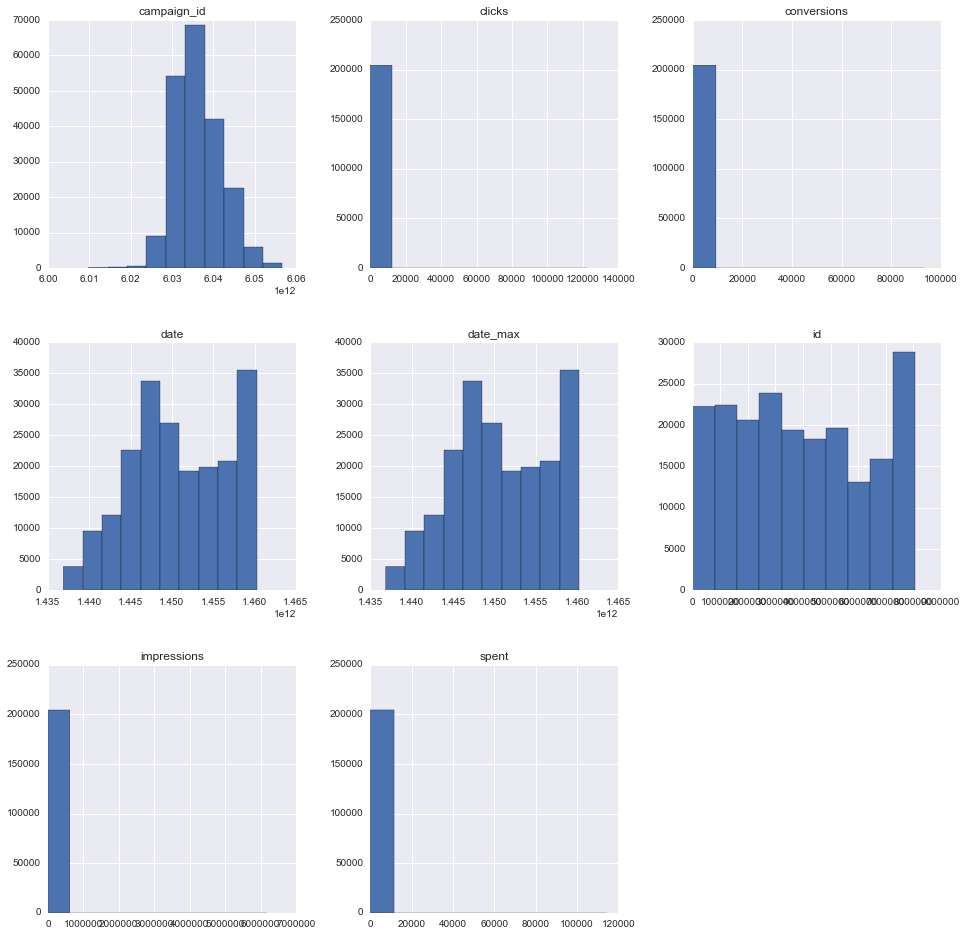

In [78]:
new_ad_max.hist(figsize=(16,16))

In [69]:
new_ad_max.corr()

,id,ad_id,adset_id,campaign_id,date,clicks,spent,impressions,conversions,date_max
id,1.000000,NaN,NaN,0.742044,0.992762,-0.019712,-0.005080,-0.017051,-0.012951,0.992762
ad_id,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
adset_id,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
campaign_id,0.742044,NaN,NaN,1.000000,0.743702,-0.037729,-0.021809,-0.041528,-0.023527,0.743702
date,0.992762,NaN,NaN,0.743702,1.000000,-0.020084,-0.005512,-0.018346,-0.012542,1.000000
clicks,-0.019712,NaN,NaN,-0.037729,-0.020084,1.000000,0.540284,0.698585,0.746337,-0.020084
spent,-0.005080,NaN,NaN,-0.021809,-0.005512,0.540284,1.000000,0.479769,0.286695,-0.005512
impressions,-0.017051,NaN,NaN,-0.041528,-0.018346,0.698585,0.479769,1.000000,0.425591,-0.018346
conversions,-0.012951,NaN,NaN,-0.023527,-0.012542,0.746337,0.286695,0.425591,1.000000,-0.012542
date_max,0.992762,NaN,NaN,0.743702,1.000000,-0.020084,-0.005512,-0.018346,-0.012542,1.000000


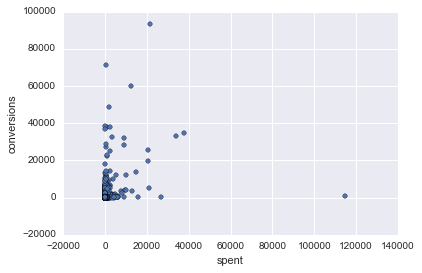

In [79]:
new_ad_max.plot(kind = 'scatter', x = 'spent', y = 'conversions')

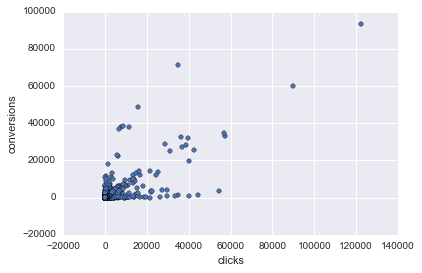

In [80]:
new_ad_max.plot(kind = 'scatter', x = 'clicks', y = 'conversions')

In [81]:
drop_spent_outliers(new_ad_max)

Dropping outliers
- n (before) = 204494
- Q1         = 0.12 ($M)
- Q2/Median  = 0.48 ($M)
- Q3         = 1.63 ($M)
- n (after)  = 179235


/Users/Edie/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [82]:
drop_clicks_outliers(new_ad_max)

Dropping outliers
- n (before) = 179235
- Q1         = 0.0 ($M)
- Q2/Median  = 1.0 ($M)
- Q3         = 5.0 ($M)
- n (after)  = 157406


/Users/Edie/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# Bids Data Exploratory

In [83]:
new_adset_bids = pd.read_csv("adset_bid.csv")

In [84]:
new_adset_bids.head()

,id,adset_id,campaign_id,reach,cpa_min,cpa_max,cpa_median,cpc_min,cpc_max,cpc_median,cpm_min,cpm_max,cpm_median,date
0,2,6027527676303,6027527674303,890000,1411,4500,3000,42,124,86,416,1354,884,1436840494959
1,3,6027528002503,6027528000703,1300000,1081,3044,2082,17,40,29,167,423,291,1436840499206
2,4,6027529269703,6027529267903,510000,946,2694,1848,15,37,27,148,383,264,1436840504160
3,5,6027417797303,6027417795703,1200000,1114,3140,2166,17,40,29,166,413,290,1436840509237
4,6,6030433163570,6030433161770,2700000,194,453,330,48,113,82,163,425,289,1436840513696


In [85]:
len(new_adset_bids)

124777

In [86]:
len(new_adset_bids.adset_id.unique())

4223

In [87]:
new_adset_bids['readable_date'] = pd.to_datetime(new_adset_bids['date'],unit='ms')

In [88]:
len(new_adset_bids)

124777

In [89]:
new_adset_bids['date_max'] = new_adset_bids.groupby(['campaign_id'])['date'].transform(max)

In [91]:
idx = new_adset_bids['date_max'] == new_adset_bids['date']
new_adset_bids_max = new_adset_bids[idx]
len(new_adset_bids_max)

4194

In [92]:
new_adset_bids_max.describe()

,id,adset_id,campaign_id,reach,cpa_min,cpa_max,cpa_median,cpc_min,cpc_max,cpc_median,cpm_min,cpm_max,cpm_median,date,date_max
count,4194.000000,4.194000e+03,4.194000e+03,4.194000e+03,4194.000000,4194.000000,4194.000000,4194.000000,4194.000000,4194.000000,4194.000000,4194.000000,4194.000000,4.194000e+03,4.194000e+03
mean,66882.907248,6.032360e+12,6.032298e+12,2.794145e+06,203.847163,559.489032,385.753934,16.722699,46.336433,31.827849,130.622556,413.859323,266.597043,1.444256e+12,1.444256e+12
std,39257.450634,3.630417e+09,3.707338e+09,1.411424e+07,1133.782966,2927.722377,2036.567091,41.968651,130.777555,83.790361,405.351771,1176.590219,761.796781,2.939961e+09,2.939961e+09
min,44.000000,6.017864e+12,6.013117e+12,2.000000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.436860e+12,1.436860e+12
25%,31276.250000,6.029788e+12,6.029779e+12,2.600000e+04,1.000000,3.000000,2.000000,1.000000,1.250000,1.000000,10.000000,44.250000,28.000000,1.442018e+12,1.442018e+12
50%,65088.500000,6.032246e+12,6.032184e+12,1.600000e+05,19.000000,53.000000,38.000000,6.000000,15.000000,11.000000,74.000000,231.000000,153.000000,1.445009e+12,1.445009e+12
75%,104819.750000,6.034095e+12,6.034092e+12,9.800000e+05,56.000000,158.000000,108.000000,17.750000,44.000000,32.000000,164.000000,510.000000,335.000000,1.446732e+12,1.446732e+12
max,124778.000000,6.045695e+12,6.045606e+12,3.690000e+08,19327.000000,49139.000000,34192.000000,1274.000000,3304.000000,2361.000000,17444.000000,53909.000000,34326.000000,1.447800e+12,1.447800e+12


In [93]:
new_adset_bids_max.corr()

,id,adset_id,campaign_id,reach,cpa_min,cpa_max,cpa_median,cpc_min,cpc_max,cpc_median,cpm_min,cpm_max,cpm_median,date,date_max
id,1.000000,0.498161,0.478618,-0.045124,-0.162322,-0.151141,-0.157470,-0.124182,-0.043424,-0.074001,-0.092028,-0.104141,-0.103399,0.965448,0.965448
adset_id,0.498161,1.000000,0.989228,0.009417,0.074846,0.077673,0.074952,0.031899,0.050656,0.044907,0.039427,0.033802,0.035131,0.504067,0.504067
campaign_id,0.478618,0.989228,1.000000,0.008654,0.075525,0.078449,0.075759,0.034840,0.053094,0.047596,0.039861,0.034554,0.035823,0.484907,0.484907
reach,-0.045124,0.009417,0.008654,1.000000,-0.022125,-0.021998,-0.022313,-0.014594,-0.016457,-0.016383,-0.012195,-0.011384,-0.011527,-0.051986,-0.051986
cpa_min,-0.162322,0.074846,0.075525,-0.022125,1.000000,0.995048,0.997667,0.427462,0.315167,0.357996,0.293982,0.313329,0.316210,-0.175669,-0.175669
cpa_max,-0.151141,0.077673,0.078449,-0.021998,0.995048,1.000000,0.999341,0.449634,0.354534,0.391898,0.292702,0.315806,0.317609,-0.165492,-0.165492
cpa_median,-0.157470,0.074952,0.075759,-0.022313,0.997667,0.999341,1.000000,0.442805,0.341078,0.380687,0.293654,0.315344,0.317618,-0.171736,-0.171736
cpc_min,-0.124182,0.031899,0.034840,-0.014594,0.427462,0.449634,0.442805,1.000000,0.932215,0.970675,0.774186,0.786560,0.790053,-0.150475,-0.150475
cpc_max,-0.043424,0.050656,0.053094,-0.016457,0.315167,0.354534,0.341078,0.932215,1.000000,0.990862,0.606067,0.644820,0.638378,-0.072495,-0.072495
cpc_median,-0.074001,0.044907,0.047596,-0.016383,0.357996,0.391898,0.380687,0.970675,0.990862,1.000000,0.676708,0.709521,0.705697,-0.102760,-0.102760


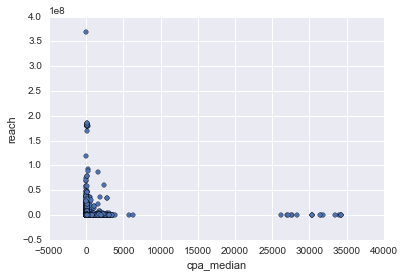

In [94]:
new_adset_bids_max.plot(kind = 'scatter', x = 'cpa_median', y = 'reach')

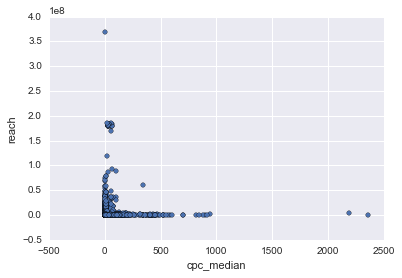

In [95]:
new_adset_bids_max.plot(kind = 'scatter', x = 'cpc_median', y = 'reach')

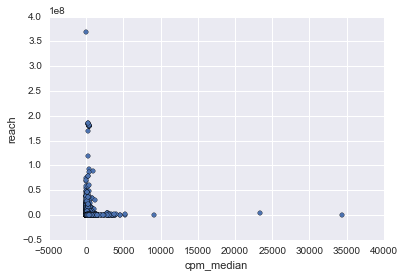

In [96]:
new_adset_bids_max.plot(kind = 'scatter', x = 'cpm_median', y = 'reach')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x141583950>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1458bc210>]], dtype=object)

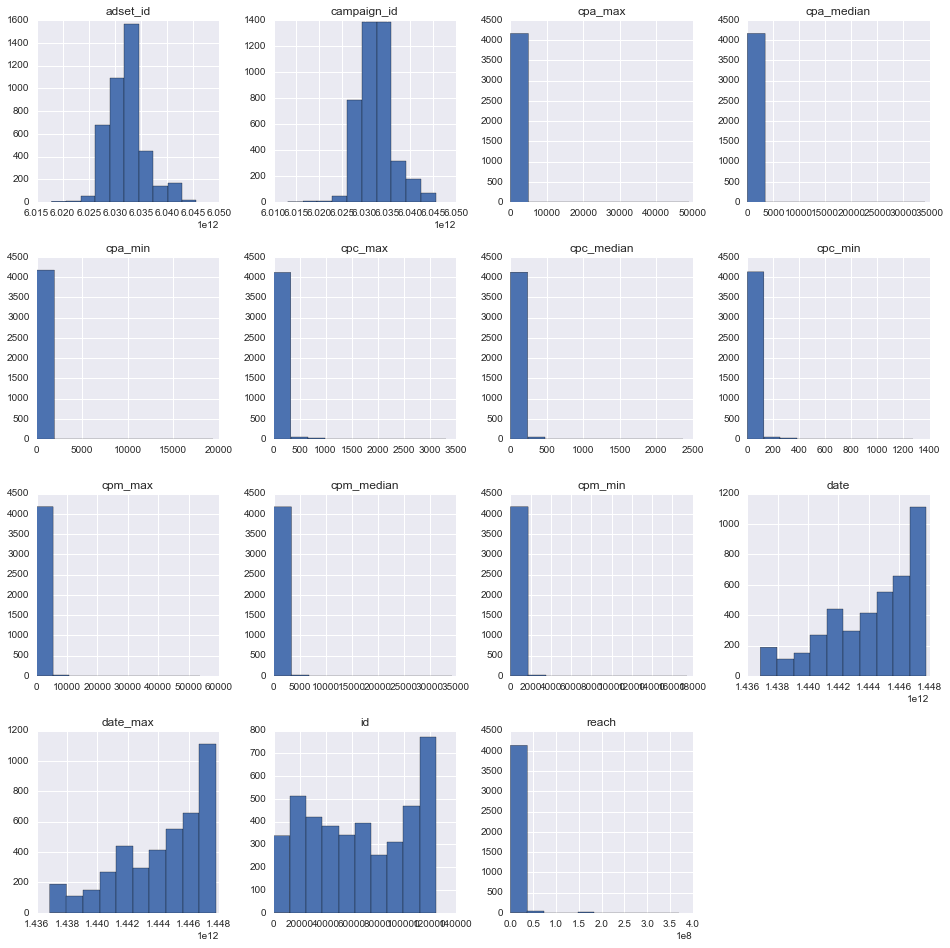

In [97]:
new_adset_bids_max.hist(figsize=(16,16))

# Bid Type Exporatory

In [243]:
new_bids_type = pd.read_csv("bid_type.csv")

In [244]:
new_bids_type.columns

Index([u'campaign_group_id', u'bidStrategy', u'maxBid'], dtype='object')

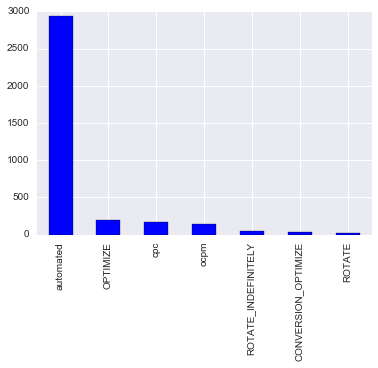

In [245]:
new_bids_type.bidStrategy.value_counts().plot(kind='bar')

# Merging Datasets

In [128]:
new_camp_raw = pd.read_csv("camp_stat.csv")

In [129]:
new_adset_raw = pd.read_csv("adset_stat.csv")

In [130]:
new_adset_bids_raw = pd.read_csv("adset_bid.csv")

In [131]:
new_camp_raw['date_max'] = new_camp_raw.groupby(['campaign_id'])['date'].transform(max)
idx = new_camp_raw['date_max'] == new_camp_raw['date']
camp_max = new_camp_raw[idx]

In [132]:
new_adset_raw['date_max'] = new_adset_raw.groupby(['adset_id'])['date'].transform(max)
idx = new_adset_raw['date_max'] == new_adset_raw['date']
adset_max = new_adset_raw[idx]

In [133]:
new_adset_bids_raw['date_max'] = new_adset_bids_raw.groupby(['adset_id'])['date'].transform(max)
idx = new_adset_bids_raw['date_max'] == new_adset_bids_raw['date']
bid_max = new_adset_bids_raw[idx]

In [134]:
print len(new_camp_raw)
print len(new_adset_raw)
print len(new_adset_bids_raw)

#Merge between bids data and adsets data
bids_adset = new_adset_bids_raw.merge(new_adset_raw,left_on=['adset_id','date'],right_on=['adset_id','date'],how='inner')

130784
345625
124777


In [135]:
bids_adset.head()

,id_x,adset_id,campaign_id_x,reach,cpa_min,cpa_max,cpa_median,cpc_min,cpc_max,cpc_median,...,date,date_max_x,id_y,campaign_id_y,clicks,spent,impressions,conversions,objective,date_max_y
0,2,6027527676303,6027527674303,890000,1411,4500,3000,42,124,86,...,1436840494959,1437267485039,135,6027527674303,18,22.97,1643,3,WEBSITE_CONVERSIONS,1437267485039
1,3,6027528002503,6027528000703,1300000,1081,3044,2082,17,40,29,...,1436840499206,1437335616042,136,6027528000703,81,39.33,5149,1,WEBSITE_CONVERSIONS,1437335616042
2,4,6027529269703,6027529267903,510000,946,2694,1848,15,37,27,...,1436840504160,1437260841370,137,6027529267903,181,75.48,13970,2,WEBSITE_CONVERSIONS,1437260841370
3,5,6027417797303,6027417795703,1200000,1114,3140,2166,17,40,29,...,1436840509237,1436862768774,138,6027417795703,285,119.44,14541,5,WEBSITE_CONVERSIONS,1436862768774
4,6,6030433163570,6030433161770,2700000,194,453,330,48,113,82,...,1436840513696,1437017909899,139,6030433161770,2379,1833.28,210144,1242,MOBILE_APP_INSTALLS,1437017909899


In [136]:
# Merge between bids data and campaigns data
bid_adset_campaign_raw = bids_adset.merge(new_camp_raw,left_on=['campaign_id_x','date'],right_on=['campaign_id','date'],how='inner')

In [137]:
len(bid_adset_campaign_raw)

122604

In [138]:
bid_adset_campaign_raw.head()

,id_x,adset_id,campaign_id_x,reach,cpa_min,cpa_max,cpa_median,cpc_min,cpc_max,cpc_median,...,objective_x,date_max_y,id,campaign_id,clicks_y,spent_y,impressions_y,conversions_y,objective_y,date_max
0,2,6027527676303,6027527674303,890000,1411,4500,3000,42,124,86,...,WEBSITE_CONVERSIONS,1437267485039,98,6027527674303,18,22.97,1643,3,WEBSITE_CONVERSIONS,1437267485039
1,3,6027528002503,6027528000703,1300000,1081,3044,2082,17,40,29,...,WEBSITE_CONVERSIONS,1437335616042,99,6027528000703,81,39.33,5149,1,WEBSITE_CONVERSIONS,1437335616042
2,4,6027529269703,6027529267903,510000,946,2694,1848,15,37,27,...,WEBSITE_CONVERSIONS,1437260841370,100,6027529267903,181,75.48,13970,2,WEBSITE_CONVERSIONS,1437260841370
3,5,6027417797303,6027417795703,1200000,1114,3140,2166,17,40,29,...,WEBSITE_CONVERSIONS,1436862768774,101,6027417795703,285,119.44,14541,5,WEBSITE_CONVERSIONS,1436862768774
4,6,6030433163570,6030433161770,2700000,194,453,330,48,113,82,...,MOBILE_APP_INSTALLS,1437017909899,102,6030433161770,2379,1833.28,210144,1242,MOBILE_APP_INSTALLS,1437017909899


In [139]:
bid_adset_campaign_raw.columns

Index([u'id_x', u'adset_id', u'campaign_id_x', u'reach', u'cpa_min',
       u'cpa_max', u'cpa_median', u'cpc_min', u'cpc_max', u'cpc_median',
       u'cpm_min', u'cpm_max', u'cpm_median', u'date', u'date_max_x', u'id_y',
       u'campaign_id_y', u'clicks_x', u'spent_x', u'impressions_x',
       u'conversions_x', u'objective_x', u'date_max_y', u'id', u'campaign_id',
       u'clicks_y', u'spent_y', u'impressions_y', u'conversions_y',
       u'objective_y', u'date_max'],
      dtype='object')

In [127]:
bid_adset_campaign_raw['date_max'] = bid_adset_campaign_raw.groupby(['adset_id','campaign_id_x'])['date'].transform(max)

# Aggregations on the Campaign level

In [140]:
len(camp_max)

3454

In [141]:
camp_max.describe()

,id,campaign_id,date,clicks,spent,impressions,conversions,date_max
count,3454.000000,3.454000e+03,3.454000e+03,3454.000000,3454.000000,3454.000000,3454.000000,3.454000e+03
mean,64860.712218,6.036459e+12,1.449856e+12,3093.199189,681.556497,194184.497105,2739.557035,1.449856e+12
std,38732.518676,6.027056e+09,6.563293e+09,23204.795693,6598.758436,2150604.152885,19904.952240,6.563293e+09
min,124.000000,6.009724e+12,1.436860e+12,0.000000,0.000000,1.000000,0.000000,1.436860e+12
25%,31526.500000,6.032088e+12,1.444885e+12,68.250000,22.505000,5005.750000,11.000000,1.444885e+12
50%,62729.000000,6.035864e+12,1.449273e+12,334.500000,78.555000,20366.000000,119.000000,1.449273e+12
75%,97751.250000,6.040657e+12,1.455898e+12,1250.250000,281.312500,77414.250000,658.000000,1.455898e+12
max,130785.000000,6.056712e+12,1.460237e+12,841512.000000,271614.710000,68916999.000000,603245.000000,1.460237e+12


In [142]:
len(new_adset_bids_raw)

124777

In [143]:
new_adset_bids_raw.describe()

,id,adset_id,campaign_id,reach,cpa_min,cpa_max,cpa_median,cpc_min,cpc_max,cpc_median,cpm_min,cpm_max,cpm_median,date,date_max
count,124777.000000,1.247770e+05,1.247770e+05,1.247770e+05,124777.000000,124777.000000,124777.000000,124777.000000,124777.000000,124777.000000,124777.000000,124777.000000,124777.000000,1.247770e+05,1.247770e+05
mean,62390.000000,6.032291e+12,6.032246e+12,2.722798e+06,110.866057,313.194034,213.755828,15.983787,44.945463,30.865704,105.513941,344.922542,220.173518,1.444008e+12,1.444767e+12
std,36020.161607,3.594697e+09,3.635557e+09,1.248499e+07,755.102079,1973.603490,1361.132426,43.679183,142.162431,90.297157,324.702203,988.330839,638.037687,2.854984e+09,2.855970e+09
min,2.000000,6.017864e+12,6.013117e+12,2.000000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.436840e+12,1.436860e+12
25%,31196.000000,6.029719e+12,6.029719e+12,2.500000e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.442015e+12,1.442939e+12
50%,62390.000000,6.032481e+12,6.032293e+12,1.400000e+05,14.000000,39.000000,27.000000,5.000000,13.000000,9.000000,59.000000,197.000000,127.000000,1.444865e+12,1.445834e+12
75%,93584.000000,6.034110e+12,6.034107e+12,9.700000e+05,47.000000,127.000000,89.000000,16.000000,41.000000,29.000000,138.000000,462.000000,301.000000,1.446322e+12,1.447075e+12
max,124778.000000,6.045695e+12,6.045606e+12,3.750000e+08,28723.000000,67172.000000,48492.000000,1431.000000,3904.000000,2394.000000,17891.000000,56983.000000,35876.000000,1.447800e+12,1.447800e+12


In [144]:
new_adset_bids_raw.head()

,id,adset_id,campaign_id,reach,cpa_min,cpa_max,cpa_median,cpc_min,cpc_max,cpc_median,cpm_min,cpm_max,cpm_median,date,date_max
0,2,6027527676303,6027527674303,890000,1411,4500,3000,42,124,86,416,1354,884,1436840494959,1437267485039
1,3,6027528002503,6027528000703,1300000,1081,3044,2082,17,40,29,167,423,291,1436840499206,1437335616042
2,4,6027529269703,6027529267903,510000,946,2694,1848,15,37,27,148,383,264,1436840504160,1437260841370
3,5,6027417797303,6027417795703,1200000,1114,3140,2166,17,40,29,166,413,290,1436840509237,1436862768774
4,6,6030433163570,6030433161770,2700000,194,453,330,48,113,82,163,425,289,1436840513696,1437017909899


In [145]:
len(new_adset_bids_raw)

124777

In [146]:
new_adset_bids_raw['date_max'] = new_adset_bids_raw.groupby(['adset_id'])['date'].transform(max)
idx = new_adset_bids_raw['date_max'] == new_adset_bids_raw['date']
adset_bid_max = new_adset_bids_raw[idx]

In [147]:
len(adset_bid_max)

4223

In [148]:
adset_bid_max.head()

,id,adset_id,campaign_id,reach,cpa_min,cpa_max,cpa_median,cpc_min,cpc_max,cpc_median,cpm_min,cpm_max,cpm_median,date,date_max
42,44,6027417090903,6027417089903,920000,1383,4387,3000,46,135,91,413,1380,872,1436859792992,1436859792992
50,52,6027417797303,6027417795703,1200000,1184,3170,2199,16,41,29,164,413,291,1436862768774,1436862768774
65,67,6027418019503,6027418015503,29000,1011,2993,2003,15,42,28,138,412,268,1436866362227,1436866362227
66,68,6027419447703,6027419446303,290000,1595,4247,3000,47,120,84,486,1590,1011,1436866364856,1436866364856
75,77,6027012039453,6027012037453,3200000,136,374,259,13,34,23,153,505,320,1436866374187,1436866374187


In [149]:
# Group adsets bids data into using campaign id and aggreagate other values
adset_bid_max_grouped = adset_bid_max.groupby('campaign_id').agg({'campaign_id':'first',
                                          'reach':sum,
                                          'cpa_min': sum, 
                                          'cpa_max': sum,
                                          'cpa_median':sum,
                                          'cpc_min':sum,
                                          'cpc_max':sum,
                                          'cpc_median':sum,
                                          'cpm_min':sum,
                                          'cpm_max':sum,
                                          'cpm_median':sum,
                                          'date': 'first'})

In [150]:
len(adset_bid_max_grouped)

1546

In [151]:
adset_bid_max_grouped.head()

,cpa_median,cpc_max,cpc_median,cpc_min,reach,campaign_id,date,cpa_max,cpa_min,cpm_max,cpm_min,cpm_median
campaign_id,,,,,,,,,,,,
6013117409178,150,24,16,10,5500000,6013117409178,1441893381113,229,66,184,53,116
6017864285805,0,0,0,0,10440,6017864285805,1444309296369,0,0,0,0,0
6018432964859,9,3,2,1,2000000,6018432964859,1447079542322,13,4,46,6,28
6019023215259,0,0,0,0,17039000,6019023215259,1444909150348,0,0,0,0,0
6019087139259,30,25,18,6,119620000,6019087139259,1443880108096,43,12,394,59,193


In [152]:
adset_bid_max_grouped.columns

Index([u'cpa_median', u'cpc_max', u'cpc_median', u'cpc_min', u'reach',
       u'campaign_id', u'date', u'cpa_max', u'cpa_min', u'cpm_max', u'cpm_min',
       u'cpm_median'],
      dtype='object')

In [154]:
adset_bid_max_grouped2 = adset_bid_max_grouped[['campaign_id','reach','cpa_min','cpa_max','cpa_median','cpc_min','cpc_max','cpc_median','cpm_min','cpm_max','cpm_median','date']]

In [155]:
adset_bid_max_grouped2.head()

,campaign_id,reach,cpa_min,cpa_max,cpa_median,cpc_min,cpc_max,cpc_median,cpm_min,cpm_max,cpm_median,date
campaign_id,,,,,,,,,,,,
6013117409178,6013117409178,5500000,66,229,150,10,24,16,53,184,116,1441893381113
6017864285805,6017864285805,10440,0,0,0,0,0,0,0,0,0,1444309296369
6018432964859,6018432964859,2000000,4,13,9,1,3,2,6,46,28,1447079542322
6019023215259,6019023215259,17039000,0,0,0,0,0,0,0,0,0,1444909150348
6019087139259,6019087139259,119620000,12,43,30,6,25,18,59,394,193,1443880108096


In [156]:
adset_bid_max_grouped2 = adset_bid_max_grouped2.set_index(['campaign_id'])

In [157]:
adset_bid_max_grouped2.head()

,reach,cpa_min,cpa_max,cpa_median,cpc_min,cpc_max,cpc_median,cpm_min,cpm_max,cpm_median,date
campaign_id,,,,,,,,,,,
6013117409178,5500000,66,229,150,10,24,16,53,184,116,1441893381113
6017864285805,10440,0,0,0,0,0,0,0,0,0,1444309296369
6018432964859,2000000,4,13,9,1,3,2,6,46,28,1447079542322
6019023215259,17039000,0,0,0,0,0,0,0,0,0,1444909150348
6019087139259,119620000,12,43,30,6,25,18,59,394,193,1443880108096


In [158]:
adset_bid_max_grouped = adset_bid_max_grouped2.reset_index()

In [159]:
adset_bid_max_grouped.head()

,campaign_id,reach,cpa_min,cpa_max,cpa_median,cpc_min,cpc_max,cpc_median,cpm_min,cpm_max,cpm_median,date
0,6013117409178,5500000,66,229,150,10,24,16,53,184,116,1441893381113
1,6017864285805,10440,0,0,0,0,0,0,0,0,0,1444309296369
2,6018432964859,2000000,4,13,9,1,3,2,6,46,28,1447079542322
3,6019023215259,17039000,0,0,0,0,0,0,0,0,0,1444909150348
4,6019087139259,119620000,12,43,30,6,25,18,59,394,193,1443880108096


In [160]:
len(adset_bid_max_grouped)

1546

In [161]:
# merge adset bids data with campaigns data
final_bid_camp_max = adset_bid_max_grouped.merge(camp_max,left_on=['campaign_id','date'],right_on=['campaign_id','date'],how='inner')

In [163]:
len(final_bid_camp_max)

1381

In [164]:
final_bid_camp_max.columns

Index([u'campaign_id', u'reach', u'cpa_min', u'cpa_max', u'cpa_median',
       u'cpc_min', u'cpc_max', u'cpc_median', u'cpm_min', u'cpm_max',
       u'cpm_median', u'date', u'id', u'clicks', u'spent', u'impressions',
       u'conversions', u'objective', u'date_max'],
      dtype='object')

In [165]:
final_bid_camp_max.head()

,campaign_id,reach,cpa_min,cpa_max,cpa_median,cpc_min,cpc_max,cpc_median,cpm_min,cpm_max,cpm_median,date,id,clicks,spent,impressions,conversions,objective,date_max
0,6013117409178,5500000,66,229,150,10,24,16,53,184,116,1441893381113,16489,395455,91659.21,68916999,34112,WEBSITE_CONVERSIONS,1441893381113
1,6017864285805,10440,0,0,0,0,0,0,0,0,0,1444309296369,27824,2823,3773.24,2656843,1973,WEBSITE_CLICKS,1444309296369
2,6018432964859,2000000,4,13,9,1,3,2,6,46,28,1447079542322,47991,4580,134.88,117747,4008,PAGE_LIKES,1447079542322
3,6019023215259,17039000,0,0,0,0,0,0,0,0,0,1444909150348,31710,54726,9801.15,2287107,45652,WEBSITE_CLICKS,1444909150348
4,6019087139259,119620000,12,43,30,6,25,18,59,394,193,1443880108096,25315,19003,832.88,341145,17444,PAGE_LIKES,1443880108096


In [166]:
final_bid_camp_max = final_bid_camp_max[['campaign_id','reach','cpa_min','cpa_max','cpa_median','cpc_min','cpc_max','cpc_median','cpm_min','cpm_max','cpm_median','clicks','spent','impressions','conversions','objective','date']]

In [167]:
final_bid_camp_max.head()

,campaign_id,reach,cpa_min,cpa_max,cpa_median,cpc_min,cpc_max,cpc_median,cpm_min,cpm_max,cpm_median,clicks,spent,impressions,conversions,objective,date
0,6013117409178,5500000,66,229,150,10,24,16,53,184,116,395455,91659.21,68916999,34112,WEBSITE_CONVERSIONS,1441893381113
1,6017864285805,10440,0,0,0,0,0,0,0,0,0,2823,3773.24,2656843,1973,WEBSITE_CLICKS,1444309296369
2,6018432964859,2000000,4,13,9,1,3,2,6,46,28,4580,134.88,117747,4008,PAGE_LIKES,1447079542322
3,6019023215259,17039000,0,0,0,0,0,0,0,0,0,54726,9801.15,2287107,45652,WEBSITE_CLICKS,1444909150348
4,6019087139259,119620000,12,43,30,6,25,18,59,394,193,19003,832.88,341145,17444,PAGE_LIKES,1443880108096


In [168]:
final_bid_camp_max.corr()

,campaign_id,reach,cpa_min,cpa_max,cpa_median,cpc_min,cpc_max,cpc_median,cpm_min,cpm_max,cpm_median,clicks,spent,impressions,conversions,date
campaign_id,1.000000,0.017536,0.053963,0.055398,0.053942,0.009885,0.029591,0.022905,0.009849,0.010110,0.009249,-0.115695,-0.107252,-0.142668,-0.042408,0.443419
reach,0.017536,1.000000,-0.017584,-0.017653,-0.017745,-0.015619,-0.019813,-0.018554,0.033349,0.033484,0.033494,0.033266,-0.000624,0.004495,0.035299,-0.005389
cpa_min,0.053963,-0.017584,1.000000,0.998448,0.999355,0.588063,0.474113,0.522654,0.530612,0.539568,0.543788,-0.003016,0.026058,-0.003483,-0.013468,-0.088042
cpa_max,0.055398,-0.017653,0.998448,1.000000,0.999745,0.598019,0.493906,0.538796,0.533895,0.544301,0.548024,-0.002980,0.026348,-0.003622,-0.013907,-0.081519
cpa_median,0.053942,-0.017745,0.999355,0.999745,1.000000,0.595720,0.487908,0.534279,0.533730,0.543459,0.547458,-0.003099,0.026222,-0.003618,-0.013919,-0.085149
cpc_min,0.009885,-0.015619,0.588063,0.598019,0.595720,1.000000,0.939681,0.977266,0.750401,0.740748,0.747238,-0.005361,0.030516,-0.003744,0.008048,-0.090156
cpc_max,0.029591,-0.019813,0.474113,0.493906,0.487908,0.939681,1.000000,0.990195,0.649372,0.653183,0.654165,-0.008487,0.023585,-0.006058,0.005870,-0.036712
cpc_median,0.022905,-0.018554,0.522654,0.538796,0.534279,0.977266,0.990195,1.000000,0.701796,0.700492,0.703640,-0.007782,0.026211,-0.005493,0.006661,-0.058793
cpm_min,0.009849,0.033349,0.530612,0.533895,0.533730,0.750401,0.649372,0.701796,1.000000,0.991783,0.996228,0.010733,0.030874,-0.007471,0.032075,-0.068532
cpm_max,0.010110,0.033484,0.539568,0.544301,0.543459,0.740748,0.653183,0.700492,0.991783,1.000000,0.998882,0.006848,0.026516,-0.009636,0.026926,-0.073219


In [169]:
final_bid_camp_max = final_bid_camp_max[final_bid_camp_max.clicks != 0]

In [170]:
# calculate cost per click
final_bid_camp_max['cost_per_click']= final_bid_camp_max['spent'] / final_bid_camp_max['clicks']

In [174]:
# calculate cost per impression
final_bid_camp_max['cost_per_impression']= final_bid_camp_max['spent'] / final_bid_camp_max['impressions']

In [176]:
# calculate cost per conversion
final_bid_camp_max['cost_per_conversion']= final_bid_camp_max['spent'] / final_bid_camp_max['conversions']

In [171]:
final_bid_camp_max.head()

,campaign_id,reach,cpa_min,cpa_max,cpa_median,cpc_min,cpc_max,cpc_median,cpm_min,cpm_max,cpm_median,clicks,spent,impressions,conversions,objective,date,cost_per_click
0,6013117409178,5500000,66,229,150,10,24,16,53,184,116,395455,91659.21,68916999,34112,WEBSITE_CONVERSIONS,1441893381113,0.231782
1,6017864285805,10440,0,0,0,0,0,0,0,0,0,2823,3773.24,2656843,1973,WEBSITE_CLICKS,1444309296369,1.336606
2,6018432964859,2000000,4,13,9,1,3,2,6,46,28,4580,134.88,117747,4008,PAGE_LIKES,1447079542322,0.029450
3,6019023215259,17039000,0,0,0,0,0,0,0,0,0,54726,9801.15,2287107,45652,WEBSITE_CLICKS,1444909150348,0.179095
4,6019087139259,119620000,12,43,30,6,25,18,59,394,193,19003,832.88,341145,17444,PAGE_LIKES,1443880108096,0.043829


In [172]:
# transform to dollar amount
final_bid_camp_max.cpa_min = final_bid_camp_max.cpa_min / (100 * 1.0)
final_bid_camp_max.cpa_max = final_bid_camp_max.cpa_max / (100 * 1.0)
final_bid_camp_max.cpa_median = final_bid_camp_max.cpa_median / (100 * 1.0)
final_bid_camp_max.cpc_min = final_bid_camp_max.cpc_min / (100 * 1.0)
final_bid_camp_max.cpc_max = final_bid_camp_max.cpc_max / (100 * 1.0)
final_bid_camp_max.cpc_median = final_bid_camp_max.cpc_median / (100 * 1.0)
final_bid_camp_max.cpm_min = final_bid_camp_max.cpm_min / (100 * 1.0)
final_bid_camp_max.cpm_max = final_bid_camp_max.cpm_max / (100 * 1.0)
final_bid_camp_max.cpm_median = final_bid_camp_max.cpm_median / (100 * 1.0)

In [272]:
final_bid_camp_max[['spent','conversions','cost_per_click','cost_per_conversion','cost_per_impression','objective']].head()

,spent,conversions,cost_per_click,cost_per_conversion,cost_per_impression,objective
5,460.09,43,0.531896,10.699767,0.023532,WEBSITE_CONVERSIONS
9,335.08,173,1.438112,1.936879,0.017003,PAGE_LIKES
16,143.99,217,0.385000,0.663548,0.008463,WEBSITE_CLICKS
20,221.26,111,1.615036,1.993333,0.008017,WEBSITE_CLICKS
21,100.17,289,0.287845,0.346609,0.004243,POST_ENGAGEMENT


In [180]:
objective_df = pd.get_dummies(final_bid_camp_max.objective, prefix = 'Objective')
objective_df.head()

,Objective_EVENT_RESPONSES,Objective_LEAD_GENERATION,Objective_LOCAL_AWARENESS,Objective_MOBILE_APP_ENGAGEMENT,Objective_MOBILE_APP_INSTALLS,Objective_NONE,Objective_PAGE_LIKES,Objective_POST_ENGAGEMENT,Objective_VIDEO_VIEWS,Objective_WEBSITE_CLICKS,Objective_WEBSITE_CONVERSIONS
0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,1,0,0,0,0


In [181]:
final_bid_camp_max = final_bid_camp_max.join([objective_df])

final_bid_camp_max.columns

Index([u'campaign_id', u'reach', u'cpa_min', u'cpa_max', u'cpa_median',
       u'cpc_min', u'cpc_max', u'cpc_median', u'cpm_min', u'cpm_max',
       u'cpm_median', u'clicks', u'spent', u'impressions', u'conversions',
       u'objective', u'date', u'cost_per_click', u'cost_per_impression',
       u'cost_per_conversion', u'Objective_EVENT_RESPONSES',
       u'Objective_LEAD_GENERATION', u'Objective_LOCAL_AWARENESS',
       u'Objective_MOBILE_APP_ENGAGEMENT', u'Objective_MOBILE_APP_INSTALLS',
       u'Objective_NONE', u'Objective_PAGE_LIKES',
       u'Objective_POST_ENGAGEMENT', u'Objective_VIDEO_VIEWS',
       u'Objective_WEBSITE_CLICKS', u'Objective_WEBSITE_CONVERSIONS'],
      dtype='object')

In [182]:
# Calculate cost per conversion
final_bid_camp_max['cost_per_conversion']= final_bid_camp_max['spent'] / final_bid_camp_max['conversions']

In [249]:
len(final_bid_camp_max)

828

In [184]:
final_bid_camp_max = final_bid_camp_max.dropna()
len(final_bid_camp_max)

1357

In [185]:
final_bid_camp_max.head()

,campaign_id,reach,cpa_min,cpa_max,cpa_median,cpc_min,cpc_max,cpc_median,cpm_min,cpm_max,...,Objective_LEAD_GENERATION,Objective_LOCAL_AWARENESS,Objective_MOBILE_APP_ENGAGEMENT,Objective_MOBILE_APP_INSTALLS,Objective_NONE,Objective_PAGE_LIKES,Objective_POST_ENGAGEMENT,Objective_VIDEO_VIEWS,Objective_WEBSITE_CLICKS,Objective_WEBSITE_CONVERSIONS
0,6013117409178,5500000,0.66,2.29,1.50,0.10,0.24,0.16,0.53,1.84,...,0,0,0,0,0,0,0,0,0,1
1,6017864285805,10440,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0,0,0,0,0,0,0,0,1,0
2,6018432964859,2000000,0.04,0.13,0.09,0.01,0.03,0.02,0.06,0.46,...,0,0,0,0,0,1,0,0,0,0
3,6019023215259,17039000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0,0,0,0,0,0,0,0,1,0
4,6019087139259,119620000,0.12,0.43,0.30,0.06,0.25,0.18,0.59,3.94,...,0,0,0,0,0,1,0,0,0,0


In [186]:
final_bid_camp_max.columns

Index([u'campaign_id', u'reach', u'cpa_min', u'cpa_max', u'cpa_median',
       u'cpc_min', u'cpc_max', u'cpc_median', u'cpm_min', u'cpm_max',
       u'cpm_median', u'clicks', u'spent', u'impressions', u'conversions',
       u'objective', u'date', u'cost_per_click', u'cost_per_impression',
       u'cost_per_conversion', u'Objective_EVENT_RESPONSES',
       u'Objective_LEAD_GENERATION', u'Objective_LOCAL_AWARENESS',
       u'Objective_MOBILE_APP_ENGAGEMENT', u'Objective_MOBILE_APP_INSTALLS',
       u'Objective_NONE', u'Objective_PAGE_LIKES',
       u'Objective_POST_ENGAGEMENT', u'Objective_VIDEO_VIEWS',
       u'Objective_WEBSITE_CLICKS', u'Objective_WEBSITE_CONVERSIONS'],
      dtype='object')

In [187]:
final_bid_camp_max = final_bid_camp_max[final_bid_camp_max.conversions != 0]

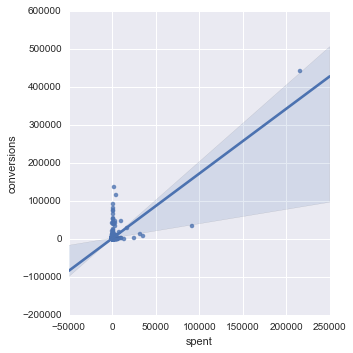

In [212]:
sns.lmplot('spent', 'conversions', final_bid_camp_max)

In [213]:
drop_spent_outliers(final_bid_camp_max)

Dropping outliers
- n (before) = 1176
- Q1         = 28.3125 ($M)
- Q2/Median  = 95.135 ($M)
- Q3         = 296.805 ($M)
- n (after)  = 1025


In [214]:
drop_conversions_outliers(final_bid_camp_max)

Dropping outliers
- n (before) = 1025
- Q1         = 22.0 ($M)
- Q2/Median  = 123.0 ($M)
- Q3         = 501.0 ($M)
- n (after)  = 894


In [215]:
drop_clicks_outliers(final_bid_camp_max)

Dropping outliers
- n (before) = 894
- Q1         = 76.25 ($M)
- Q2/Median  = 223.0 ($M)
- Q3         = 553.5 ($M)
- n (after)  = 828


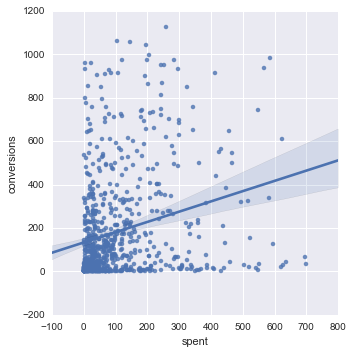

In [234]:
sns.lmplot('spent', 'conversions', final_bid_camp_max)

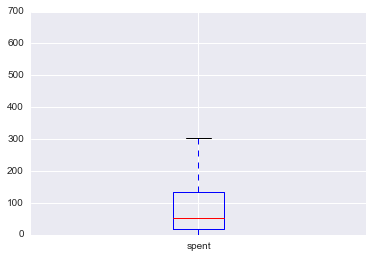

In [239]:
final_bid_camp_max[ ['spent'] ].plot(kind = 'box')

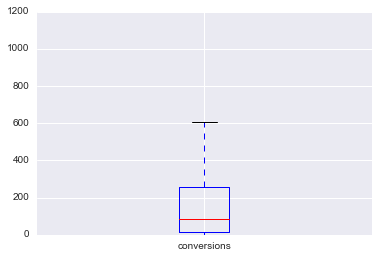

In [240]:
final_bid_camp_max[ ['conversions'] ].plot(kind = 'box')

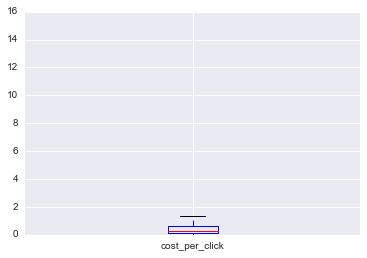

In [241]:
final_bid_camp_max[ ['cost_per_click'] ].plot(kind = 'box')

In [282]:
#Merge between bids data and adsets data
final_bid_type_camp_max = final_bid_camp_max.merge(new_bids_type,left_on=['campaign_id'],right_on=['campaign_group_id'],how='inner')

In [283]:
# Lenght without outlier
print len(final_bid_camp_max)
print len(final_bid_type_camp_max)

828
710


In [284]:
final_bid_type_camp_max.columns

Index([u'campaign_id', u'reach', u'cpa_min', u'cpa_max', u'cpa_median',
       u'cpc_min', u'cpc_max', u'cpc_median', u'cpm_min', u'cpm_max',
       u'cpm_median', u'clicks', u'spent', u'impressions', u'conversions',
       u'objective', u'date', u'cost_per_click', u'cost_per_impression',
       u'cost_per_conversion', u'Objective_EVENT_RESPONSES',
       u'Objective_LEAD_GENERATION', u'Objective_LOCAL_AWARENESS',
       u'Objective_MOBILE_APP_ENGAGEMENT', u'Objective_MOBILE_APP_INSTALLS',
       u'Objective_NONE', u'Objective_PAGE_LIKES',
       u'Objective_POST_ENGAGEMENT', u'Objective_VIDEO_VIEWS',
       u'Objective_WEBSITE_CLICKS', u'Objective_WEBSITE_CONVERSIONS',
       u'campaign_group_id', u'bidStrategy', u'maxBid'],
      dtype='object')

In [285]:
bid_type_df = pd.get_dummies(new_bids_type.bidStrategy, prefix = 'Bid_Type')
bid_type_df.head()

,Bid_Type_CONVERSION_OPTIMIZE,Bid_Type_OPTIMIZE,Bid_Type_ROTATE,Bid_Type_ROTATE_INDEFINITELY,Bid_Type_automated,Bid_Type_cpc,Bid_Type_ocpm
0,0,0,0,0,1,0,0
1,0,0,0,0,1,0,0
2,0,0,0,0,1,0,0
3,0,0,0,0,1,0,0
4,0,0,0,0,1,0,0


In [287]:
final_bid_type_camp_max = final_bid_type_camp_max.join([bid_type_df])

In [288]:
final_bid_type_camp_max.columns

Index([u'campaign_id', u'reach', u'cpa_min', u'cpa_max', u'cpa_median',
       u'cpc_min', u'cpc_max', u'cpc_median', u'cpm_min', u'cpm_max',
       u'cpm_median', u'clicks', u'spent', u'impressions', u'conversions',
       u'objective', u'date', u'cost_per_click', u'cost_per_impression',
       u'cost_per_conversion', u'Objective_EVENT_RESPONSES',
       u'Objective_LEAD_GENERATION', u'Objective_LOCAL_AWARENESS',
       u'Objective_MOBILE_APP_ENGAGEMENT', u'Objective_MOBILE_APP_INSTALLS',
       u'Objective_NONE', u'Objective_PAGE_LIKES',
       u'Objective_POST_ENGAGEMENT', u'Objective_VIDEO_VIEWS',
       u'Objective_WEBSITE_CLICKS', u'Objective_WEBSITE_CONVERSIONS',
       u'campaign_group_id', u'bidStrategy', u'maxBid',
       u'Bid_Type_CONVERSION_OPTIMIZE', u'Bid_Type_OPTIMIZE',
       u'Bid_Type_ROTATE', u'Bid_Type_ROTATE_INDEFINITELY',
       u'Bid_Type_automated', u'Bid_Type_cpc', u'Bid_Type_ocpm'],
      dtype='object')

In [289]:
final_bid_type_camp_max.head()

,campaign_id,reach,cpa_min,cpa_max,cpa_median,cpc_min,cpc_max,cpc_median,cpm_min,cpm_max,...,campaign_group_id,bidStrategy,maxBid,Bid_Type_CONVERSION_OPTIMIZE,Bid_Type_OPTIMIZE,Bid_Type_ROTATE,Bid_Type_ROTATE_INDEFINITELY,Bid_Type_automated,Bid_Type_cpc,Bid_Type_ocpm
0,6019632204269,4300,0.84,2.37,1.69,0.14,0.38,0.27,3.60,11.70,...,6019632204269,automated,0,0,0,0,0,1,0,0
1,6023634601941,198000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,6023634601941,automated,0,0,0,0,0,1,0,0
2,6024469111228,74000,1.12,3.11,2.14,0.15,0.37,0.27,5.16,14.43,...,6024469111228,automated,0,0,0,0,0,1,0,0
3,6025116981459,1300000,1.15,3.93,2.50,1.16,3.38,2.23,5.13,22.03,...,6025116981459,automated,0,0,0,0,0,1,0,0
4,6025234083437,93000,0.18,0.37,0.29,0.13,0.26,0.20,1.16,3.91,...,6025234083437,automated,0,0,0,0,0,1,0,0


# Modeling (Just Starting) 

In [290]:
training_df = final_bid_type_camp_max.sample(frac = .6, random_state = 1)
training_df.reset_index(inplace = True)

In [291]:
test_df = final_bid_type_camp_max.drop(training_df.index)

In [292]:
print len(final_bid_type_camp_max)
print len(test_df)

710
284


In [293]:
model = smf.ols(formula = 'conversions ~ spent + cost_per_click + Objective_PAGE_LIKES + Objective_MOBILE_APP_INSTALLS +Objective_WEBSITE_CONVERSIONS  + Bid_Type_automated + Bid_Type_cpc+ Bid_Type_ocpm + maxBid', data = training_df).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            conversions   R-squared:                       0.315
Model:                            OLS   Adj. R-squared:                  0.300
Method:                 Least Squares   F-statistic:                     21.22
Date:                Sun, 17 Apr 2016   Prob (F-statistic):           1.57e-29
Time:                        20:42:12   Log-Likelihood:                -2876.1
No. Observations:                 426   AIC:                             5772.
Df Residuals:                     416   BIC:                             5813.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------------
Intercept                       263.0739     53.990      4.873      0.000       156.947   369.201
spent                             0.8811      0.088      9.986      0.000         0.708     1.055
cost_per_click                  -97.9710     17.915     -5.469      0.000      -133.187   -62.755
Objective_PAGE_LIKES           -149.9167     45.749     -3.277      0.001      -239.845   -59.989
Objective_MOBILE_APP_INSTALLS  -182.6390     56.238     -3.248      0.001      -293.184   -72.094
Objective_WEBSITE_CONVERSIONS  -201.3242     26.220     -7.678      0.000      -252.865  -149.784
Bid_Type_automated              -34.2450     53.973     -0.634      0.526      -140.339    71.849
Bid_Type_cpc                    -81.2008     77.092     -1.053      0.293      -232.739    70.337
Bid_Type_ocpm                   -63.8564     63.829     -1.000      0.318      -189.324    61.611
maxBid                           -1.4317      2.479     -0.577      0.564        -6.305     3.442
==============================================================================
Omnibus:                      129.790   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              314.631
Skew:                           1.531   Prob(JB):                     4.77e-69
Kurtosis:                       5.889   Cond. No.                     1.72e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.72e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

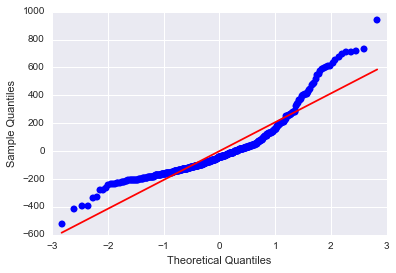

In [294]:
# Plotting qqolots to check normality assumption - Plot of the quantiles of the first dataset (vertically) against the quantiles of the second’s (horizontally)
figure = sm.qqplot(model.resid, line = 's')

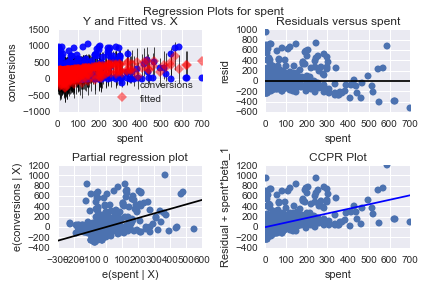

In [295]:
# to check modeling assumptions with respect to a single regressor
figure = sm.graphics.plot_regress_exog(model, 'spent')